In [104]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from typing import Dict
import os,sys
import numpy as np
from pathlib import Path
import pycocotools
import torch.utils
from torch.utils.data import ConcatDataset, DataLoader, DistributedSampler
from functools import partial
import json
import pickle
import time
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [87]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [102]:
annotations_dir = '/content/gdrive/MyDrive/DL_systems/final_project/data/annotations'
output_dir = '/content/gdrive/MyDrive/DL_systems/final_project/output'
mdetr_git_dir = '/content/gdrive/MyDrive/DL_systems/final_project/mdetr'
image_dir = '/content/gdrive/MyDrive/DL_systems/final_project/data/images'

In [4]:
models = ['efficientnetB3', 'efficientnetB5', 'resnet101']

In [5]:
#load annotations file
masked_anns = json.load(open(os.path.join(annotations_dir, 'flickr_test_masked.json'), 'r'))

In [6]:
#Define lookups for masked_ann
image_id_lookup = {x["id"]: x for x in masked_anns["images"]}
ann_id_lookup = {f"{x['image_id']}_{x['tokens_positive']}" : x for x in masked_anns['annotations']}

In [7]:
#Load eval results for masked objects and for all phrases in image
eval_results = {}
flickr_results = {}
for model in models:
  pkl_file = open(os.path.join(output_dir, 'eval_results', f'rtx8000_mdetr_{model}_10_masked_token_results.pkl'), 'rb')
  eval_results[model] = pickle.load(pkl_file)
  pkl_file.close()
  pkl_file = open(os.path.join(output_dir, 'eval_results', f'rtx8000_mdetr_{model}_25_flickr_results.pkl'), 'rb')
  flickr_results[model] = pickle.load(pkl_file)
  pkl_file.close()

## For how many image/caption pairs do we draw bounding boxes at different confidence levels?

Confidence levels to test: [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

In [8]:
def get_predicted_boxes(output, c):
  '''
  Function to count the number of boxes predicted for a given image/caption output result above a certain confidence level

  Inputs:
  -------
    output : results dict with keys "image_id", "sentence_id", "boxes", "scores". Boxes and scores each are lists of 100 elements
    c : confidence level (threshold for scores)
  '''
  scores = np.array(output['scores'])
  boxes = np.array(output['boxes'])
  keep = np.where(scores>=c)[0]
  #Return the boxes predicted and count if there are any boxes above the confidence threshold
  if len(keep)>0:
    
    return boxes[keep], len(boxes[keep])
  
  #If no boxes predicted return an empty list for boxes and 0 for the count
  else:
    #print("No boxes predicted")
    return [], 0


Loop through confidence levels and generate lists of predictd boxes and counts at each one

In [82]:
#Loop through confidence levels and generate lists of predictd boxes and counts at each one
pred_boxes = {}
count_pred_boxes = {}
confidence_levels = np.arange(0.1, 1, 0.05)

for model in models:
  pred_boxes[model] = {}
  count_pred_boxes[model] = {}
  for c in confidence_levels:
    pred_boxes[model][c] = []
    count_pred_boxes[model][c] = np.empty(len(eval_results[model]))
    for i, res in enumerate(eval_results[model]):
      boxes, count = get_predicted_boxes(res, c)
      pred_boxes[model][c].append(boxes)
      count_pred_boxes[model][c][i] = count

Get aggregate stats on the boxes for which we actually predict results

In [103]:
acc_no_boxes = {}
for model in models:
  acc_no_boxes[model] = []
  for i,c in enumerate(confidence_levels):
    count_no_boxes =len(np.where(count_pred_boxes[model][c]==0)[0])
    total = len(count_pred_boxes[model][c])
    acc = count_no_boxes/total
    acc_no_boxes[model].append(acc)

    #print(f"% of instances with no boxes predicted at threshold {c}: {acc_no_boxes[model][i]}")

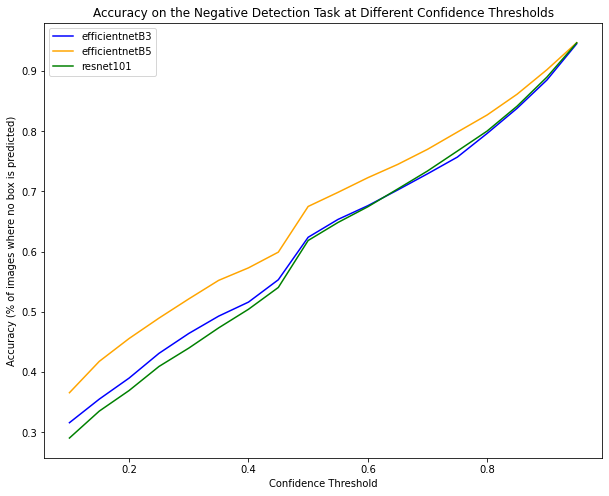

In [123]:
fig = plt.figure(figsize = (10,8))
colors = ['blue', 'orange', 'green']
for i, model in enumerate(models):
  plt.plot(confidence_levels, acc_no_boxes[model], label = model, color = colors[i])
  plt.xlabel("Confidence Threshold")
  plt.ylabel("Accuracy (% of images where no box is predicted)")
  plt.legend(loc = 'best')
  plt.title("Accuracy on the Negative Detection Task at Different Confidence Thresholds")

### Visualize examples

In [115]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
def plot_results(pil_img, scores, boxes, labels):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    assert len(scores) == len(boxes) == len(labels)
    for s, (xmin, ymin, xmax, ymax), l,  c in zip(scores, boxes, labels, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()

{'file_name': '7162685234.jpg', 'height': '333', 'width': '500', 'id': 2, 'caption': 'Two children playing on the swings in the sand with the ocean in the background', 'dataset_name': 'flickr', 'tokens_negative': [[0, 78]], 'sentence_id': 0, 'original_img_id': 7162685234, 'tokens_positive_eval': [[[0, 12]], [[28, 33]], [[38, 46]], [[52, 61]]], 'orig_caption': 'Two children playing on the beach in the sand with the ocean in the background', 'orig_id': 153906, 'orig_sentence_id': 0, 'orig_tokens_positive_eval': [[[0, 12]], [[24, 33]], [[37, 45]], [[51, 60]]], 'pred_word': 'swings', 'masked_caption': 'Two children playing on the <mask> in the sand with the ocean in the background', 'masked_word': 'beach', 'score_raw': 0.07845847308635712, 'score_scaled': 0.25604650956963837, 'score_k': 2, 'tokens_positive_eval_idx': 1}
[0.40690746903419495, 0.3384004831314087, 0.3372224271297455, 0.2773037552833557, 0.25948089361190796, 0.21712544560432434, 0.21674294769763947, 0.17365792393684387, 0.1711

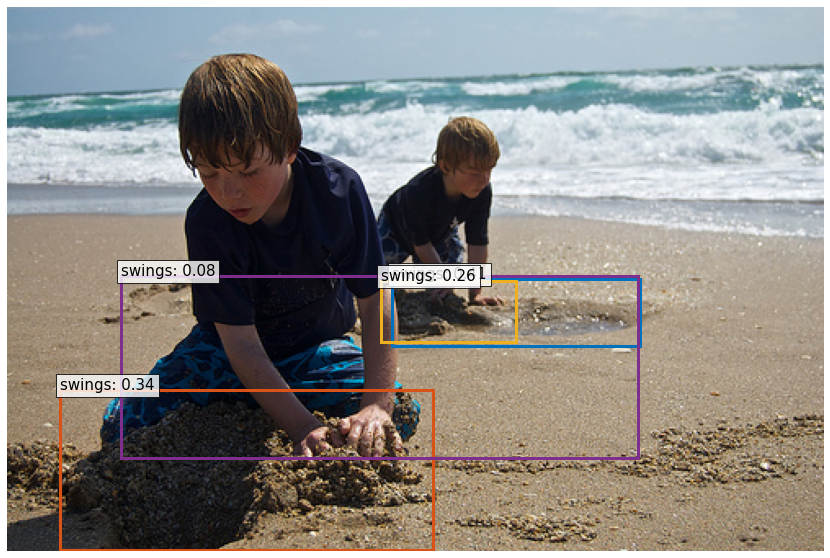

In [118]:
ex_ann = image_id_lookup[2]
print(ex_ann)
ex_results = eval_results['resnet101'][2]
print(ex_results['scores'])
im = Image.open(os.path.join(image_dir, ex_ann['file_name']))

plot_results(im, [scores for i, scores in enumerate(ex_results['scores']) if i in([0,2,4,20])], 
             [boxes for i, boxes in enumerate(ex_results['boxes']) if i in([0,2,4,20])], ['swings', 'swings', 'swings', 'swings'])


## Recall on non-negative boxes

In [18]:
!pip install transformers &> /dev/null
!pip install timm &> /dev/null

In [19]:
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
sys.path.append(mdetr_git_dir)
from datasets.flickr_eval import *

In [ ]:
len(flickr_results['efficientnetB3'])

7893

In [85]:
from copy import deepcopy
iou_thresh = 0.5

total_phrases = 0
FN = {}
TP = {}
recall_tracker = {}
for model in models:
    FN[model] = []
    TP[model] = []
    recall_tracker[model] = []
    for c in confidence_levels:
        fn = 0
        tp = 0
        for pred in flickr_results[model]:
            image_id = pred['image_id'].item()
            image_ann = image_id_lookup[image_id]
            masked_idx = image_ann['tokens_positive_eval_idx'] 
            positive_tokens_eval = image_ann['tokens_positive_eval']
            target_boxes = []
            for p in positive_tokens_eval:
                target_boxes.append(ann_id_lookup[f'{image_id}_{p}']['bbox'])

            
            #Get boxes corresponding to original phrases that haven't been masked
            boxes_non_masked = deepcopy(pred['boxes'])
            boxes_non_masked.pop(masked_idx)
            scores_non_masked = deepcopy(pred['scores'])
            scores_non_masked.pop(masked_idx)
            target_boxes_non_masked = deepcopy(target_boxes)
            target_boxes_non_masked.pop(masked_idx)
            for i, boxes in enumerate(boxes_non_masked):
              pred_non_masked = {'image_id': image_id, 'boxes': boxes, 'scores': scores_non_masked[i]}
              pred_boxes, count = get_predicted_boxes(pred_non_masked, c)
              if count==0:
                  fn += 1 
              else:
                  ious = box_iou(np.asarray(pred_boxes), np.asarray([target_boxes_non_masked[i]]))
                  assert ious.shape == (len(pred_boxes), len([target_boxes_non_masked[i]]))
                  max_iou = np.max(ious)
                  if max_iou>= 0:
                    tp += 1
        FN[model].append(fn)
        TP[model].append(tp)
        recall = tp/(fn+tp)
        print(f"Recall for model {model} @ threshold {c}: {recall}")
        recall_tracker[model].append(recall)
            

Recall for model efficientnetB3 @ threshold 0.1: 0.8663406272058082
Recall for model efficientnetB3 @ threshold 0.15000000000000002: 0.8380558636684481
Recall for model efficientnetB3 @ threshold 0.20000000000000004: 0.8090148230311586
Recall for model efficientnetB3 @ threshold 0.25000000000000006: 0.7682262781082989
Recall for model efficientnetB3 @ threshold 0.30000000000000004: 0.7226983966925481
Recall for model efficientnetB3 @ threshold 0.3500000000000001: 0.5923666431380458
Recall for model efficientnetB3 @ threshold 0.40000000000000013: 0.5698800040334778
Recall for model efficientnetB3 @ threshold 0.45000000000000007: 0.5313602904104063
Recall for model efficientnetB3 @ threshold 0.5000000000000001: 0.36588686094585054
Recall for model efficientnetB3 @ threshold 0.5500000000000002: 0.2548149642028839
Recall for model efficientnetB3 @ threshold 0.6000000000000002: 0.24079862861752546
Recall for model efficientnetB3 @ threshold 0.6500000000000001: 0.22446304325905012
Recall for

'\nfor cur_boxes, phrase in zip(pred_boxes, phrases):\n    target_boxes = self.imgid2boxes[str(pred["image_id"])][phrase["phrase_id"]]\n\n    ious = box_iou(np.asarray(cur_boxes), np.asarray(target_boxes))\n    for k in self.topk:\n        maxi = 0\n        if k == -1:\n            maxi = ious.max()\n        else:\n            assert k > 0\n            maxi = ious[:k].max()\n        if maxi >= self.iou_thresh:\n            recall_tracker.add_positive(k, "all")\n            for phrase_type in phrase["phrase_type"]:\n                recall_tracker.add_positive(k, phrase_type)\n        else:\n            recall_tracker.add_negative(k, "all")\n            for phrase_type in phrase["phrase_type"]:\n                recall_tracker.add_negative(k, phrase_type)\n\n'

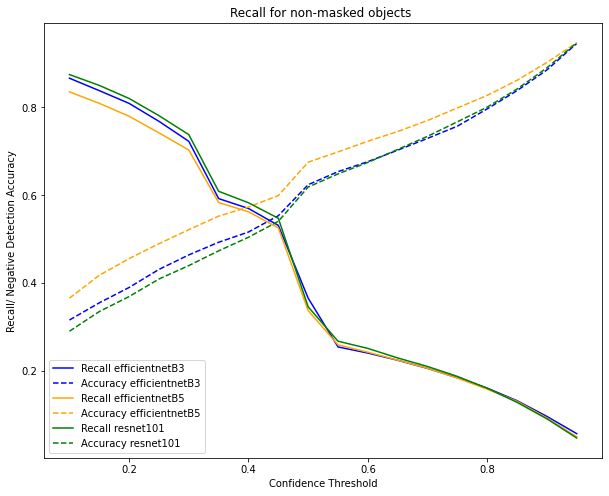

In [124]:
fig = plt.figure(figsize = (10,8))
colors = ['blue', 'orange', 'green']
for i, model in enumerate(models):
  plt.plot(confidence_levels, recall_tracker[model], label = f'Recall {model}', color = colors[i])
  plt.plot(confidence_levels, acc_no_boxes[model], '--', label = f'Accuracy {model}', color = colors[i])
  plt.xlabel("Confidence Threshold")
  plt.ylabel("Recall/ Negative Detection Accuracy")
  plt.legend(loc = 'best')
  plt.title("Recall for non-masked objects ")

### Visualize same example when we care about recall

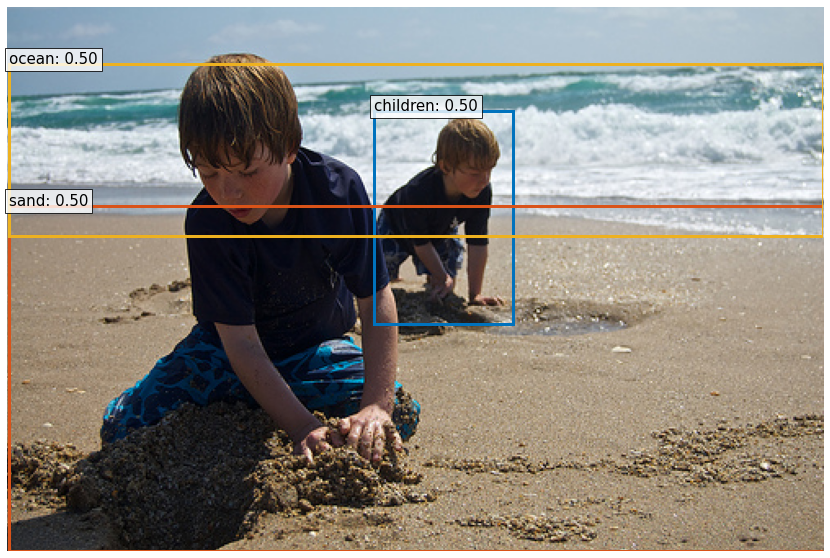

In [132]:
ex_flickr_results = flickr_results['resnet101'][2]
plot_results(im, [scores[0] for i, scores in enumerate(ex_flickr_results['scores'])if i!=1],
             [boxes[0] for i, boxes in enumerate(ex_flickr_results['boxes'])if i!=1], ['children', 'sand','ocean'])

## Analysis of outputs when we do predict a box
We want to look at, when the model does make a bbox prediction, how much overlap there is with that prediction and the original annotated bounding box for the replaced object. If there is high overlap, we can conclude the model has done a worse job in understanding the differences between objects

In [12]:
def get_orig_bbox(image_ann, annotations, ann_id_lookup):
  '''
  This function takes as input one of the masked image annotations and returns the bounding box annotation for the original 
  object that the masked object replaced

  Inputs:
  -------
    image annotation: dict from the annotations['images'] list
  '''
  #Get the relevant tokens_positive_eval object for the masked object
  masked_idx = image_ann['tokens_positive_eval_idx']
  positive_token = image_ann['tokens_positive_eval'][masked_idx]

  image_id = image_ann['id'] #get unique image id for pulling the correct associated annotation object

  ann_object = ann_id_lookup[f'{image_id}_{positive_token}']

  #Retrieve relevant bounding box ffrom annotation
  bbox = ann_object['bbox']
  return bbox


In [13]:
masked_orig_bbox = {}

for model in models:
    masked_orig_bbox[model] = []
    for i, res in enumerate(eval_results[model]):
      image_id = res['image_id'].item()
      image_ann = image_id_lookup[image_id]

      masked_orig_bbox[model].append(get_orig_bbox(image_ann, masked_anns['annotations'], ann_id_lookup))
      
      assert len(masked_orig_bbox[model])-1==i

      pkl_file = open(os.path.join(output_dir, f'{model}_masked_original_bboxes.pkl'), 'wb')
      pickle.dump(masked_orig_bbox, pkl_file)
      pkl_file.close()


In [133]:
from numpy.core.fromnumeric import reshape
IOU_orig_pred = {}
IOU_masked_preds = {}
counter = 0
for model in models:
  IOU_masked_preds[model] = []
  for i, res in enumerate(eval_results[model]):

    #First check if model predicted any boxes above a set confidence threshold (will do 0.7 as standard)

    #if res['scores'][0]>= 0.7:
    pred_boxes, count = get_predicted_boxes(res, 0.5)
    #Get most confident bounding box prediction from model outputs
    if count> 0:
      ious = box_iou(np.asarray(pred_boxes), np.asarray([masked_orig_bbox[model][i]]))
      IOU_masked_preds[model].append(np.max(ious))

      #IOU_masked_preds.
      #IOU_orig_pred[model].append(get_iou(top_pred_bbox, orig_bbox))
    else:
      continue
    
  print(f"Average IOU between masked and original object for model {model} at confidence level 0.7: {np.mean(IOU_masked_preds[model])}")

  

Average IOU between masked and original object for model efficientnetB3 at confidence level 0.7: 0.1329000326709942
Average IOU between masked and original object for model efficientnetB5 at confidence level 0.7: 0.14352634079661866
Average IOU between masked and original object for model resnet101 at confidence level 0.7: 0.1357196643668084


In [23]:
import seaborn as sns

In [134]:
iou_df= pd.DataFrame(IOU_masked_preds['efficientnetB3'], columns = ['IOU'])
iou_df['model'] = 'efficientnetB3'
iou_df_b5= pd.DataFrame(IOU_masked_preds['efficientnetB5'], columns = ['IOU'])
iou_df_b5['model'] = 'efficientnetB5'

iou_df = iou_df.append(iou_df_b5)
iou_df_resnet101= pd.DataFrame(IOU_masked_preds['resnet101'], columns = ['IOU'])
iou_df_resnet101['model'] = 'resnet101'

iou_df = iou_df.append(iou_df_resnet101)

iou_df.shape

(8542, 2)

Text(0.5, 1.0, 'Distribution of IOU between Original Bounding Box and Predicted for Masked Objects')

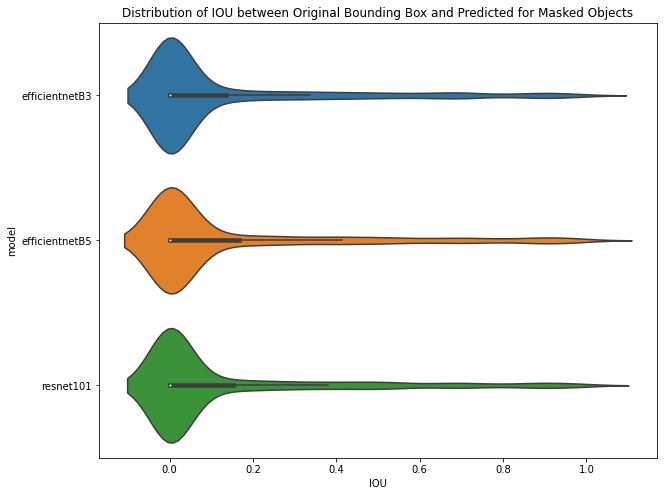

In [135]:
fig = plt.figure(figsize = (10,8))
ax = sns.violinplot(x = iou_df['IOU'], y = iou_df['model'])
ax.set_title("Distribution of IOU between Original Bounding Box and Predicted for Masked Objects")

## Analysis of MLM scores and accuracy

In [137]:
#get quartiles of all MLM scores
scores_raw = [img['score_raw'] for img in masked_anns['images']]
scores_scaled = [img['score_scaled'] for img in masked_anns['images']]

scores_raw_quartile = [np.percentile(scores_raw, i) for i in [25, 50, 75, 95]]
scores_raw_quartile =  [0] + scores_raw_quartile
scores_scaled_quartile = [np.percentile(scores_scaled, i) for i in [25, 50, 75, 95]]

In [57]:
eval_results_MLM_conf = {}
for model in models:
  eval_results_MLM_conf[model] = {}
  for j, p in enumerate(scores_raw_quartile):
      eval_results_MLM_conf[model][p] = []
  
  for i, res in enumerate(eval_results[model]):
      image_id = res['image_id'].item()
      image_ann = image_id_lookup[image_id]
      for j, p in enumerate(scores_raw_quartile):
          if image_ann['score_raw']>=p:
              eval_results_MLM_conf[model][p].append(res)

for model in models:
    for p in scores_raw_quartile:
        print(len(eval_results_MLM_conf[model][p])) 

7893
5920
3947
1974
395
7893
5920
3947
1974
395
7893
5920
3947
1974
395


In [136]:
eval_results_MLM_conf2 = {}
for model in models:
  eval_results_MLM_conf2[model] = {}
  for j, p in enumerate(scores_raw_quartile):
      eval_results_MLM_conf2[model][p] = []
  
  for i, res in enumerate(eval_results[model]):
      image_id = res['image_id'].item()
      image_ann = image_id_lookup[image_id]
      for j, p in enumerate(scores_raw_quartile):
          if p <1:
              if image_ann['score_raw']<p:
                  eval_results_MLM_conf2[model][p].append(res)
          else:
              continue


In [58]:
pred_boxes_MLM = {}
count_pred_boxes_MLM = {}
for model in models:
  pred_boxes_MLM [model] = {}
  count_pred_boxes_MLM [model] = {}
  for p in scores_raw_quartile:
      pred_boxes_MLM [model][p] = {}
      count_pred_boxes_MLM [model][p] = {}
      for c in confidence_levels:
          pred_boxes_MLM [model][p][c] = []
          count_pred_boxes_MLM [model][p][c] = np.empty(len(eval_results_MLM_conf[model][p]))
          for i, res in enumerate(eval_results_MLM_conf[model][p]):
              boxes, count = get_predicted_boxes(res, c)
              pred_boxes_MLM[model][p][c].append(boxes)
              count_pred_boxes_MLM[model][p][c][i] = count

In [59]:
acc_no_boxes_MLM = {}
for model in models:
  acc_no_boxes_MLM[model] = {}
  for p in scores_raw_quartile:
    acc_no_boxes_MLM[model][p] = []
    for i,c in enumerate(confidence_levels):
      count_no_boxes =len(np.where(count_pred_boxes_MLM[model][p][c]==0)[0])
      total = len(count_pred_boxes_MLM[model][p][c])
      if total >0:
        acc = count_no_boxes/total
        acc_no_boxes_MLM[model][p].append(acc)

In [38]:
pred_boxes_MLM2 = {}
count_pred_boxes_MLM2 = {}
for model in models:
  pred_boxes_MLM2[model] = {}
  count_pred_boxes_MLM2[model] = {}
  for p in scores_raw_quartile:
      pred_boxes_MLM2[model][p] = {}
      count_pred_boxes_MLM2[model][p] = {}
      for c in confidence_levels:
          pred_boxes_MLM2[model][p][c] = []
          count_pred_boxes_MLM2[model][p][c] = np.empty(len(eval_results_MLM_conf2[model][p]))
          for i, res in enumerate(eval_results_MLM_conf2[model][p]):
              boxes, count = get_predicted_boxes(res, c)
              pred_boxes_MLM2[model][p][c].append(boxes)
              count_pred_boxes_MLM2[model][p][c][i] = count

In [ ]:
acc_no_boxes_MLM2 = {}

for model in models:
  acc_no_boxes_MLM2[model] = {}
  for p in scores_raw_quartile:
    acc_no_boxes_MLM2[model][p] = []
    for i,c in enumerate(confidence_levels):
      count_no_boxes =len(np.where(count_pred_boxes_MLM[model][p][c]==0)[0])
      total = len(count_pred_boxes_MLM[model][p][c])
      if total >0:
        acc = count_no_boxes/total
        acc_no_boxes_MLM2[model][p].append(acc)

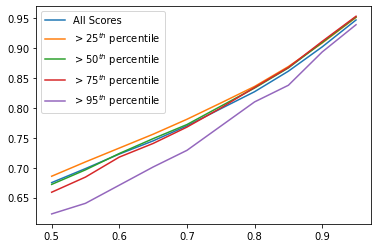

In [61]:
labels = ['All Scores', '$> 25^{th}$ percentile', '$> 50^{th}$ percentile', '$> 75^{th}$ percentile', '$> 95^{th}$ percentile']
for i, p in enumerate(scores_raw_quartile):
    plt.plot(confidence_levels, acc_no_boxes_MLM['efficientnetB5'][p], label = labels[i])
    plt.legend(loc = 'best')

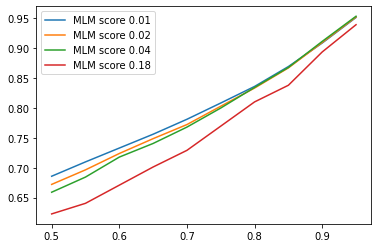

In [43]:
for p in scores_raw_quartile:

    plt.plot(confidence_levels, acc_no_boxes_MLM2['efficientnetB5'][p], label = f'MLM score {np.round(p,2)}')
    plt.legend(loc = 'best')